In [2]:
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt
from PIL import Image
from typing import Literal, Optional
from time import time
from typing import Tuple
import numba

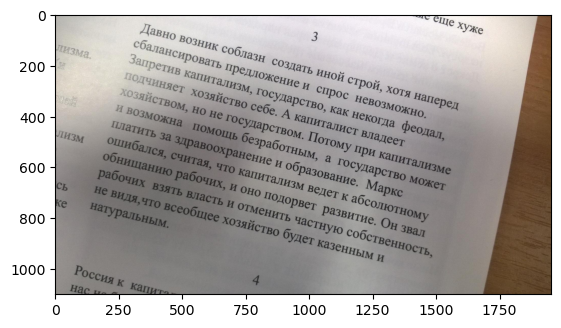

In [67]:
example_image_path = 'data/1.jpg'
input_image = np.array(Image.open(example_image_path))
plt.imshow(input_image)

Напишем функцию для предобработки изображения, как мы рассматривали на лекции: добавил blur и фильтр собеля, тем самым сделаем его черно-белым. Также расширим изображение до минимально покрывающего квадрата со стороной степени двойки.

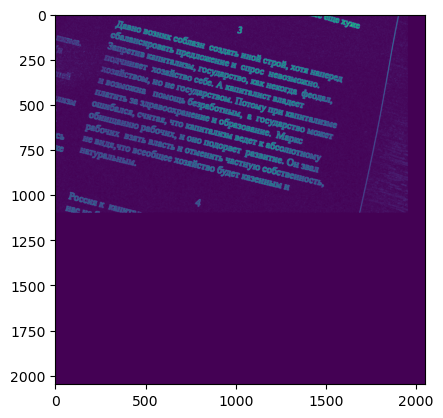

In [58]:
def prepare_image(image: np.ndarray) -> np.ndarray:
    image = cv.cvtColor(cv.GaussianBlur(image, (3, 3), 0), cv.COLOR_BGR2GRAY)
    image = cv.addWeighted(
        cv.convertScaleAbs(cv.Sobel(image, 3, 1, 0, ksize=3)), 
        0.5, 
        cv.convertScaleAbs(cv.Sobel(image, 3, 0, 1, ksize=3)), 
        0.5, 
        0)

    new_image = np.zeros(2 ** (np.log2(image.shape).astype(int) + 1))
    new_image[0:image.shape[0], 0:image.shape[1]] = image
    return new_image

plt.imshow(prepare_image(input_image))

Напишем быстрое преобразование Хафа и вычисление оптимального поворота на основе ряда с наибольшей дисперсией. 

In [61]:
# @numba.njit() # - does not work because of reshapes, but I tried...
def hough_transform(prepr_image: np.ndarray, left_border: Optional[int] = None, right_border: Optional[int] = None, where: Literal['left', 'right'] = 'left') -> np.ndarray:
    assert where in ['left', 'right']
    if left_border is None:
        left_border = 0
    if right_border is None:
        right_border = prepr_image.shape[1]
    if right_border - left_border == 1:
        return prepr_image[:, left_border].reshape((-1, 1))

    result_image = np.zeros((prepr_image.shape[0], right_border - left_border))
    middle = (left_border + right_border) // 2
    left_image = hough_transform(prepr_image, left_border, middle, where=where)
    right_image = hough_transform(prepr_image, middle, right_border, where=where)

    for shift in range(right_border - left_border):
        i = np.arange(prepr_image.shape[0])
        right_index = (i + shift // 2 + shift % 2) if where == 'left' else (i - shift // 2 - shift % 2)
        result_image[i, shift] = left_image[i, shift // 2] + \
            right_image[right_index % prepr_image.shape[0], shift // 2]

    return result_image


def find_angle(fht_image: np.ndarray) -> Tuple[float, float]:
    variance = np.var(fht_image, axis=0)
    biggest_variance_idx = np.argmax(variance)
    another_catet = fht_image.shape[1]
    return variance[biggest_variance_idx], np.arctan(biggest_variance_idx / another_catet)

prepared_image = prepare_image(input_image)
find_angle(hough_transform(prepared_image))

(1003038050.2418824, 0.23622816684744666)

Также напишем функцию для поворота изображения. 

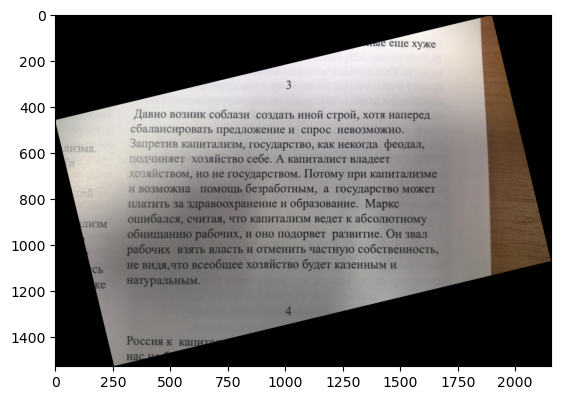

In [92]:
def rotate_image(image: np.ndarray, angle_radians: float, interp_type=cv.INTER_LINEAR) -> np.ndarray:
    angle_degrees = angle_radians * 180 / np.pi

    center = (image.shape[1] / 2, image.shape[0] / 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle_degrees, 1)
    borders = np.array([
        image.shape[0] * abs(np.sin(angle_radians)) + image.shape[1] * abs(np.cos(angle_radians)),
        image.shape[0] * abs(np.cos(angle_radians)) + image.shape[1] * abs(np.sin(angle_radians)),
    ], dtype=int)

    rotation_matrix[0, 2] += ((borders[0] / 2) - center[0])
    rotation_matrix[1, 2] += ((borders[1] / 2) - center[1])

    rotated_image= cv.warpAffine(image, rotation_matrix, borders, flags=interp_type)
    return rotated_image

plt.imshow(rotate_image(input_image, 0.236))

Остается скомбинировать результаты. Но каждое изображение необходимо крутить в обе стороны при поиске наилучшего угла, для этого придется дописать небольшую логику. 

In [71]:
def autorotate_image(image: np.ndarray, interp_type=cv.INTER_LINEAR) -> np.ndarray:
    prepr_image = prepare_image(image)
    res_left = find_angle(hough_transform(prepr_image, where='left'))
    res_right = find_angle(hough_transform(prepr_image, where='right'))
    angle = res_left[1] if res_left[0] > res_right[0] else -res_right[1]
    return rotate_image(image, angle, interp_type=interp_type)

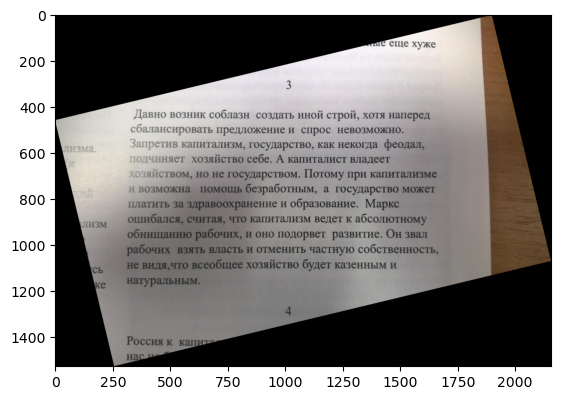

In [72]:
plt.imshow(autorotate_image(input_image))

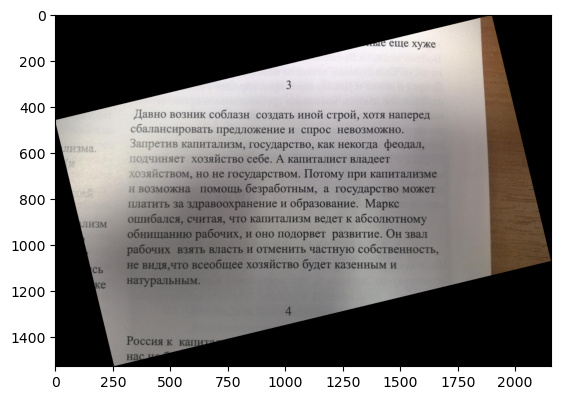

In [63]:
plt.imshow(autorotate_image(input_image, interp_type=cv.INTER_NEAREST))

Невооруженным глазом разницы не видно. Визуализируем ее. 

255


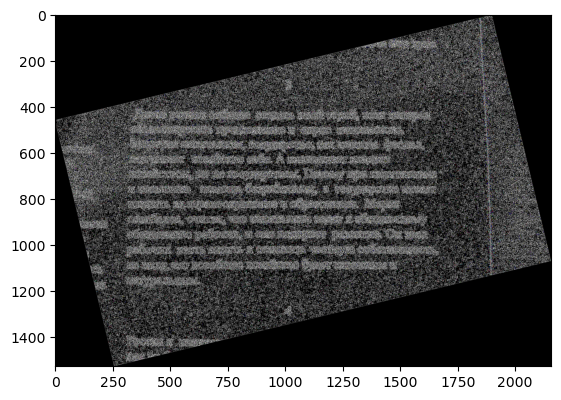

In [64]:
diff = autorotate_image(input_image) - autorotate_image(input_image, interp_type=cv.INTER_NEAREST)
print(diff.max())
plt.imshow(diff)

Все-таки видно разница есть :)
Преобразуем все изображения. 

In [73]:
import os
from tqdm import tqdm

def iterdir(path):
    return [(fn, os.path.join(path, fn)) for fn in sorted(os.listdir(path))]

resdir = 'output_images'
os.makedirs(resdir, exist_ok=True)
for bn, fn in tqdm(iterdir('data')):
    in_image = np.array(Image.open(fn))
    out_image = autorotate_image(in_image)
    Image.fromarray(out_image).save(f'{resdir}/{bn}')

100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


Посчитаем время работы

In [87]:
import time
sizes = 2 ** np.arange(3, 12, dtype=int)
perfomance = []
for size in sizes:
    t_0 = time.time()
    hough_transform(np.ones((size, size), dtype=np.uint8))
    perfomance.append(time.time() - t_0)

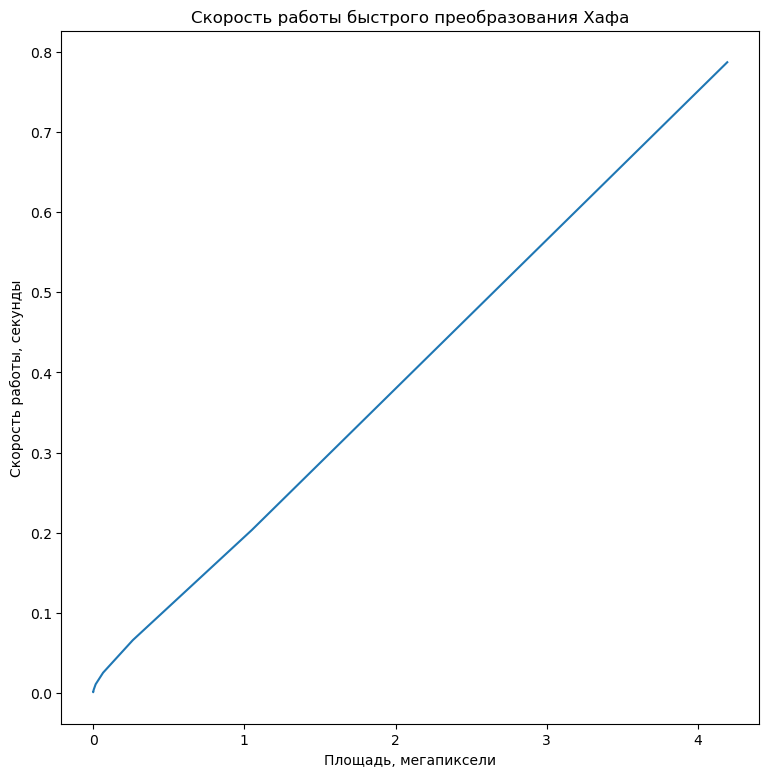

In [90]:
plt.figure(figsize=(9, 9))
plt.title('Скорость работы быстрого преобразования Хафа')
plt.xlabel('Площадь, мегапиксели')
plt.ylabel('Скорость работы, секунды')
plt.plot(sizes ** 2 / 10 ** 6, perfomance)
plt.show()

Какая красивая линейная зависимость!

Теоретическая оценка скорости работы алгоритма $O(N^2 \log(N))$, поскольку на каждом шаге деления пополам мы совершаем $O(N^2)$ действий. На таком отрезке площадей мы не заметим логарифма, поэтому можно считать, что он почти константен, тогда время должно зависеть от площади как $O(\log(N))$, то есть в нашем приближении почти линейно. Что мы и видим на графике. Это значит, что с точки зрения асимптотики мы все реализовали верно.

Аналогично с памятью - на каждом шаге разделения пополам я храню $O(N^2)$ дополнительной памяти (left_image, right_image). Поэтому итого будет также $O(N^2 \log(N))$. 

Остальные части пайплайна автоповорота работают за $O(N^2)$ по времени и не более чем за $O(N^2)$ по памяти. Поэтому суммарные асимптотики автоповорота будут теми же, что и для быстрого преобразования Хафа.